# PUI 2017 HW 9
## Yuwen Chang (ywc249)
### Data
- [NYC PUMA Shapefile](https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data)
- [ACS 1-Year Survey Data](https://api.census.gov/data/2016/acs/acs1/variables.json)

### Objective
- Assess whether the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.

# 1. Data Management: NYC PUMA
## 1.1 Obtain NYC PUMA geometry

# NYCOD API

In [2]:
import os
import io
import json
import requests
import urllib.request as urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
import shapely
import matplotlib.pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#os.system('curl -o NYCPUMA.gz ' + link1)
#os.system('unzip NYCPUMA.gz -d ' + os.getenv('PUIDATA') + '/NYCPUMA')

In [18]:
link1 = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.urlretrieve(link1, 'NYCPUMA.gz')
os.system('unzip NYCPUMA.gz -d ' + os.getenv('PUIDATA') + '/NYCPUMA')

0

In [3]:
for filename in os.listdir(os.getenv('PUIDATA') + '/NYCPUMA'):
    if 'shp' in filename:
        shpfile = filename

In [4]:
pumashp = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/NYCPUMA/' + shpfile)
print(pumashp.crs)
pumashp.head()

{'init': 'epsg:4326'}


,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


## 1.2 Plot NYC PUMA regions

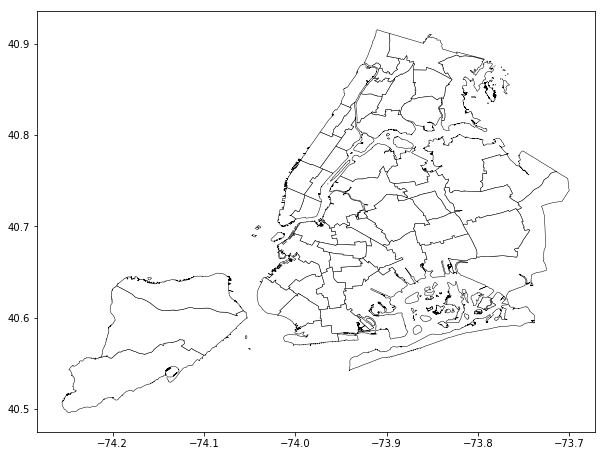

In [5]:
pumashp.plot(facecolor='w', edgecolor='k', linewidth=0.5, figsize=(10,10))

### Figure 1. The PUMA boundaries in NYC

# 2. Data Management: AFF Internet Access Data
## 2.1 Obtain data through AFF API

In [6]:
#reading in my api key saved in censusAPI.py as
from censusAPI import myAPI

In [7]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [8]:
#turning things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))

In [9]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label']) for k in affkeys
  if k.startswith ("B28002")
  and 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subs

In [10]:
#keyword for the number of households
keyNHH = 'B28002_001E'
aff1y['variables'][keyNHH]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [11]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [12]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNHH +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET',url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [13]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET',url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 Generate feature: percentage of households with broadband access

In [14]:
pumaPP.columns

Index(['B28002_001E', 'NAME', 'state', 'public use microdata area',
       'Unnamed: 4'],
      dtype='object')

In [15]:
to_merge = pumaPP[['B28002_001E', 'public use microdata area']]
pumaBB = pumaBB.merge(to_merge, on='public use microdata area')
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146


In [16]:
pumaBB.drop('Unnamed: 4', axis=1, inplace=True)
pumaBB['pcBB'] = pumaBB.B28002_004E / pumaBB.B28002_001E * 100
pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Compare with the website-published data

In [17]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
                   header=1, usecols=["Target Geo Id2","Percent","Margin of Error"])
bbpc.columns = ['gid', 'HC01', 'HC02']
bbpc.head()

,gid,HC01,HC02
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [18]:
bbpc['gid'] -= 3600000
bbpc.head()

,gid,HC01,HC02
0,-3599999,74.7,0.5
1,-3499900,70.9,2.5
2,-3499800,80.5,2.7
3,-3499699,87.0,2.8
4,-3499698,81.9,2.9


In [19]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


## check percentages, same?

# 3 Visualization
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [20]:
pumashp['puma'] = pumashp['puma'].astype(integer)

In [21]:
pumashp.shape

(55, 4)

In [129]:
BBshp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area')
BBshp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612


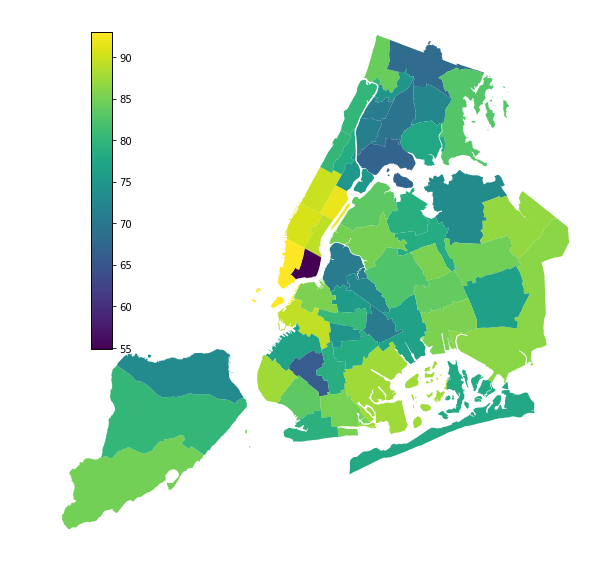

In [23]:
import choroplethNYC as cp

#cp.choroplethNYC(gdf, "column_name", kind='continuous', cmap="viridis")
cp.choroplethNYC(BBshp, column='pcBB', kind='continuous');

### Figure 2. 

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [24]:
link4 = 'https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv'
linkNYC = pd.read_csv(link4)

In [20]:
#pd.read_csv(os.getenv('PUIDATA') + 'linkNYClocations.csv')

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133
5,5,bk-01-140988,-73.957869,2017-11-03,40.717770
6,6,bk-06-125931,-73.981936,2017-02-24,40.674556
7,7,bk-06-125930,-73.979738,2017-02-24,40.677620
8,8,bk-08-125716,-73.974060,2017-11-03,40.679568
9,9,bk-06-126514,-73.974371,2017-11-03,40.679639


In [25]:
linkNYC.drop('Unnamed: 0', axis=1, inplace=True)
print(linkNYC.shape)
linkNYC.head()

(1414, 4)


,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [26]:
# combine long lat greate a "geometry" column
linkNYC['lonlat'] = list(zip(linkNYC.longitude, linkNYC.latitude))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)"
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [28]:
# combine lat and lon column to a shapely Point() object
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
linkNYC.head()
#linkNYC['geometry'] = linkNYC.apply(lambda x: shapely.geometry.Point((float(x.longitude), float(x.latitude))), axis=1)

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [29]:
linkNYC = gpd.GeoDataFrame(linkNYC, geometry='geometry')
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [31]:
linkNYC.crs = {'init': 'epsg:4326'}

# plot the location of the linkNYC stations

## I have also color coded the station by how long ago they have been installed, using the date datetime variable

/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


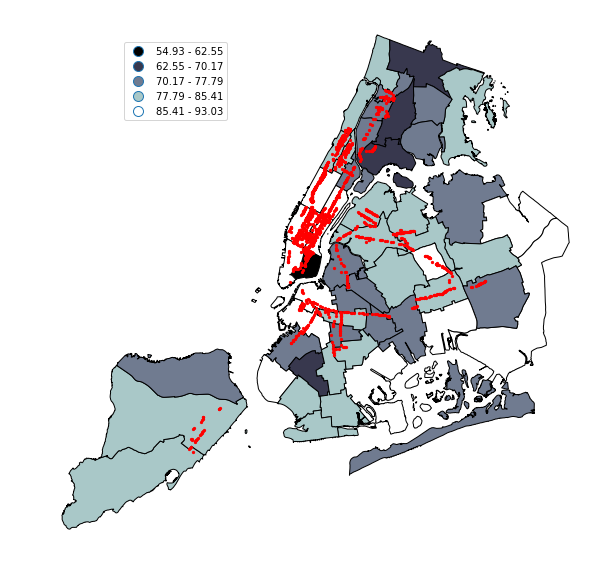

In [70]:
fig, ax, cb = cp.choroplethNYC(BBshp, column='pcBB', scheme='Equal_interval', k=5, cmap='bone',
                               edgecolor='k', width=0.5);
linkNYC.plot(color='r', markersize=5, ax=ax)

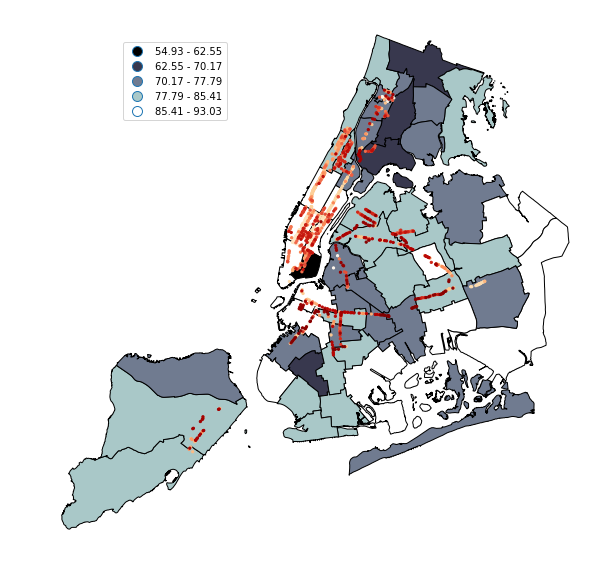

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 total population by puma and merge it into your GeoDF

In [131]:
# getting the broadband access number of households
keyPOP = 'B00001_001E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET',url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [132]:
pumaPop = pumaPop[['B00001_001E', 'public use microdata area']]
pumaPop.columns = ['pop', 'puma']
BBpopshp = BBshp.merge(pumaPop, on='puma')
BBpopshp.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB,pop
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612,2011


## 5.2 find the number of station per 100 people per PUMA

In [133]:
BBpopshp.to_crs(epsg=2263, inplace=True)
BBpopshp.crs

{'init': 'epsg:2263', 'no_defs': True}

In [120]:
linkNYC.to_crs(epsg=2263, inplace=True)
linkNYC.crs

{'init': 'epsg:2263', 'no_defs': True}

In [134]:
linkpp = gpd.sjoin(BBpopshp, linkNYC, how='left', op='contains').groupby(BBpopshp.puma).count()
linkpp = linkpp[['lonlat']]
linkpp.columns = ['link_site']

linkpp[linkpp.link_site > 0].head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


In [135]:
linkpp.reset_index(inplace=True)
pumashplc = BBpopshp.merge(linkpp, on='puma')
pumashplc.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB,pop,link_site
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,1
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,0
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141,1305,0
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737,1882,0
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612,2011,1


In [137]:
#linkNYC per 100 inhabitants
pumashplc['linkNYCp100p'] = pumashplc['link_site'] / pumashplc['pop'] * 100
pumashplc['linkNYCp100p'].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

In [47]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCpp, dtype: float64

# at last, plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals


/Users/Yuwen/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


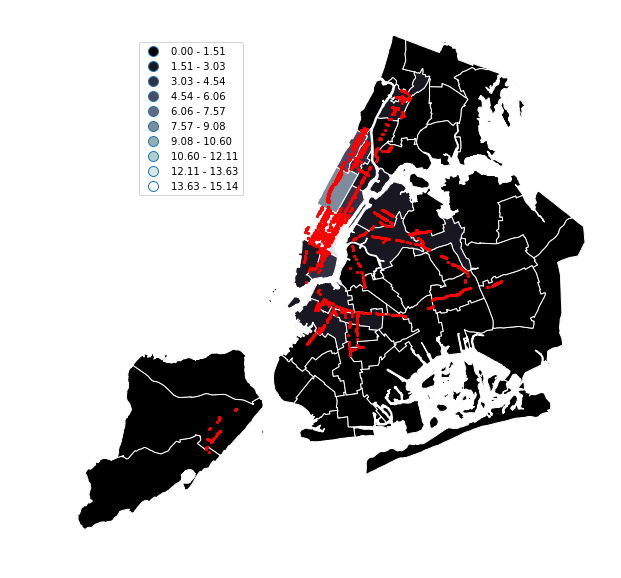

In [146]:
fig, ax, cb = cp.choroplethNYC(pumashplc, column='linkNYCp100p', scheme='Equal_interval', k=10, cmap='bone',
                               edgecolor='w', width=0.01);
linkNYC.plot(color='r', markersize=5, ax=ax)

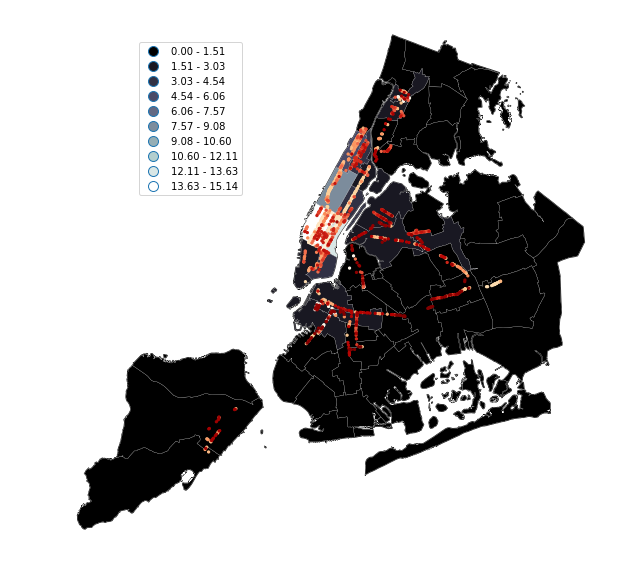

# Extra credit 1: 
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

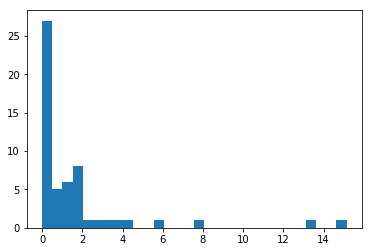

In [208]:
pl.hist(pumashplc["linkNYCpp"], bins=30);

## Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC


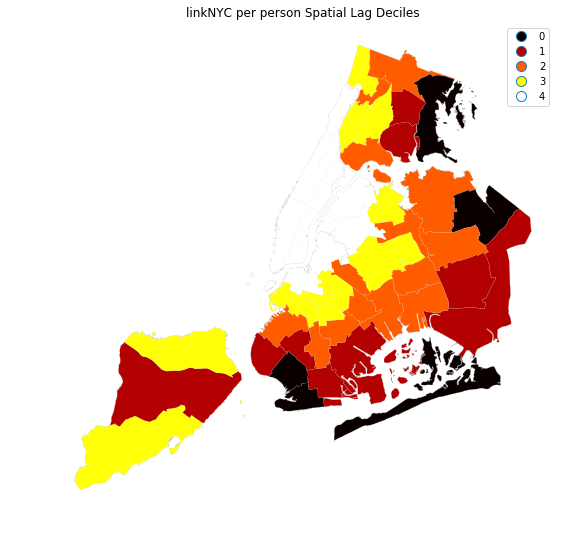

this is whay I came up with, and needs not be the same for you. But properly describe what you obtain


Note: To find the table you extracted through the API manually you could

https://factfinder.census.gov/ -> Advanced Search -> Show me all 
    
    - Topics: Housing -> Physical Characteristics -> Internet Access
    - Geographies -> all geography types -> Public Use Microdata Areas (755)
                     -> Select a State: New York -> All Pubic Use Microdaa Areas within New York
                     -> Add Your Selection
    - Years -> 2016